<h1 style="font-size:4em; "> Max-Cut Problem </h1>

First, we need to import necessary library 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import seaborn as sns
import pandas as pd

# Helper functions from Utils
from Utils import graph as ut

Let start the simple graph with 5 nodes

In [4]:
n = 5
G = nx.Graph()
V = range(n)
G.add_nodes_from(V)
E = [(0, 1, 1), (1, 2, 2), (2, 3, 3), (3, 0, 1), (1, 3, 5),(1, 4, 20)]
G.add_weighted_edges_from(E)

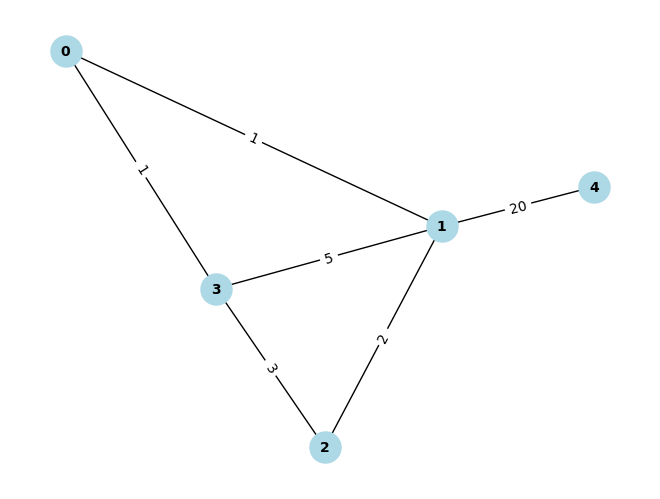

In [5]:
ut.draw_graph(G)

The MaxCut problem aims to determine how to partition (or "cut") the vertices of a graph into two disjoint subsets such that the sum of the weights of the edges crossing between the subsets is maximized.

For this graph, the maxcut bitstring is [1, 0, 0, 1, 1]

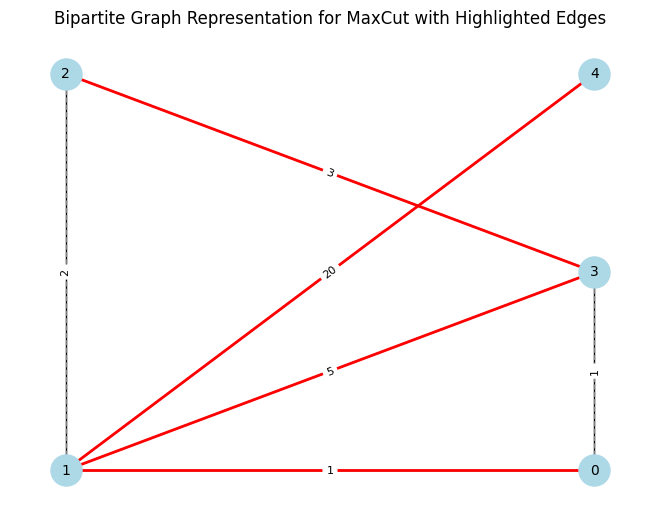

In [6]:
bitstring = [1, 0, 0, 1, 1]
ut.draw_partition_graph(G, bitstring)

So the final answer for maxcut is 29

<h1 style="font-size:3em; "> Tranform to QUBO </h1>

To generalize, Mathematical Formulation

# MaxCut Problem Formulation

Given an undirected graph $G = (V, E)$ with edge weights $w_{ij}$ for $(i, j) \in E$, the MaxCut problem can be formulated as:

$$
\text{Maximize: } \sum_{(i, j) \in E} w_{ij} (x_i + x_j - 2 x_i x_j)
$$

**Subject to:**

$$
x_i \in \{0, 1\} \quad \forall i \in V
$$

**Where:**

- $x_i \in \{0, 1\}$: Indicates the set to which vertex $i$ belongs.
  - $x_i = 0$: Vertex $i$ is in one partition.
  - $x_i = 1$: Vertex $i$ is in the other partition.
- $w_{ij}$: The weight of the edge between vertices $i$ and $j$.


# QUBO Formulation for MaxCut

The **Quadratic Unconstrained Binary Optimization (QUBO)** formulation for the MaxCut problem can be described as follows:

Given an undirected graph $G = (V, E)$ with edge weights $w_{ij}$, the goal is to partition the vertices $V$ into two disjoint subsets $S$ and $T$ such that the weight of the cut is maximized.

### Variables
- Let $x_i \in \{0, 1\}$ for each vertex $i \in V$:
  - $x_i = 0$: Vertex $i$ is in one subset.
  - $x_i = 1$: Vertex $i$ is in the other subset.

### Objective Function
The objective function can be written as:

$$
\text{Maximize: } \sum_{(i, j) \in E} w_{ij} x_i (1 - x_j) + w_{ij} \, x_j (1 - x_i)
$$

This simplifies to:

$$
\text{Maximize: } \sum_{i \in V} a_i x_i + \sum_{(i, j) \in E} b_{ij} x_i x_j
$$

Where:
- $a_i = \sum_{j:(i,j) \in E} w_{ij}$
- $b_{ij} = -2 w_{ij}$

### QUBO Matrix Form
In QUBO, we minimize an energy function represented as:

$$
\text{Maximize: } H(x) = x^T Q x
$$

Where:
- $Q$ is the QUBO matrix,
- $x$ is the vector of binary variables.

For MaxCut:

$$
Q_{ij} =
\begin{cases}
-w_{ij} & \text{if } (i, j) \in E, \\
\sum_{(i, k) \in E} w_{ik} & \text{if } i = j, \text{k is vertex that connect with i}\\
0 & \text{otherwise.}
\end{cases}
$$

### Example 1

For a simple graph:

- **Graph:** $G = (V, E)$ with:
  - $V = \{1, 2, 3\}$,
  - $E = \{(1, 2), (2, 3)\}$,
  - Weights: $w_{12} = 3$, $w_{23} = 2$.



In [5]:
n = 3
G = nx.Graph()
V = range(1, n+1)
G.add_nodes_from(V)
E = [(1, 2, 3), (2, 3, 2)]
G.add_weighted_edges_from(E)

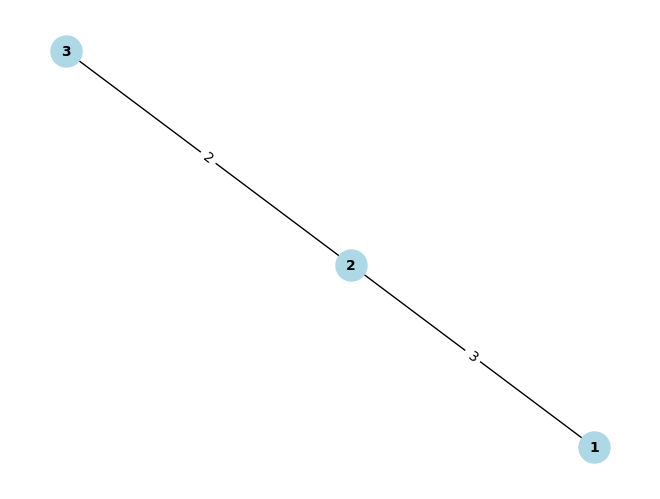

In [8]:
ut.draw_graph(G)

The QUBO matrix $Q$ is:

$$
Q =
\begin{bmatrix}
3 & -6 & 0 \\
-6 & 5 & -4 \\
0 & -4 & 2
\end{bmatrix}.
$$

There are useful function for tranform graph to QUBO

In [2]:
from qiskit_optimization.applications import Maxcut

For good understanding, I recommend to read white paper in resource "problem-formulation-guide.pdf"

First, let make adjacency matrix

In [6]:
w = nx.adjacency_matrix(G).todense()
print(w)

[[0 3 0]
 [3 0 2]
 [0 2 0]]


In [11]:
max_cut = Maxcut(w) #maka max_cut object
qp = max_cut.to_quadratic_program() #make QUBO

print(qp.prettyprint())

Problem name: Max-cut

Maximize
  -6*x_0*x_1 - 4*x_1*x_2 + 3*x_0 + 5*x_1 + 2*x_2

Subject to
  No constraints

  Binary variables (3)
    x_0 x_1 x_2



For Quadratic part

In [12]:
Quadratic = qp.objective.quadratic.to_array()
print(Quadratic)

[[ 0. -6.  0.]
 [ 0.  0. -4.]
 [ 0.  0.  0.]]


For Linear part

In [13]:
Linear = qp.objective.linear.to_array()
print(Linear)

[3. 5. 2.]


Therefore, the QUBO for this graph

In [14]:
print(ut.get_QUBO_Matrix(G))

[[ 3. -6.  0.]
 [ 0.  5. -4.]
 [ 0.  0.  2.]]


### Example 2

For a simple graph:

- **Graph:** $G = (V, E)$ with:
  - $V = \{0, 1, 2, 3, 4\}$,
  - $E = \{(0, 1), (1, 2), (2, 3), (0, 3), (1, 3), (1, 4)\}$,
  - Weights: $w_{01} = 1$, $w_{12} = 2$, $w_{23} = 3$, $w_{03} = 1$, $w_{13} = 5$, $w_{14} = 20$.

In [7]:
n = 5
G = nx.Graph()
V = range(n)
G.add_nodes_from(V)
E = [(0, 1, 1), (1, 2, 2), (2, 3, 3), (3, 0, 1), (1, 3, 5),(1, 4, 20)]
G.add_weighted_edges_from(E)

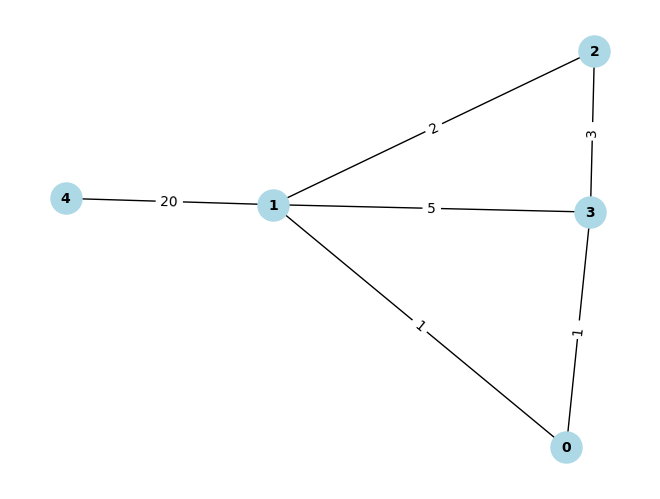

In [16]:
ut.draw_graph(G)

In [17]:
w = nx.adjacency_matrix(G).todense()
print(w)

[[ 0  1  0  1  0]
 [ 1  0  2  5 20]
 [ 0  2  0  3  0]
 [ 1  5  3  0  0]
 [ 0 20  0  0  0]]


In [18]:
max_cut = Maxcut(w) #maka max_cut object
qp = max_cut.to_quadratic_program() #make QUBO

print(qp.prettyprint())

Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 2*x_0*x_3 - 4*x_1*x_2 - 10*x_1*x_3 - 40*x_1*x_4 - 6*x_2*x_3
  + 2*x_0 + 28*x_1 + 5*x_2 + 9*x_3 + 20*x_4

Subject to
  No constraints

  Binary variables (5)
    x_0 x_1 x_2 x_3 x_4



In [19]:
print(ut.get_QUBO_Matrix(G))

[[  2.  -2.   0.  -2.   0.]
 [  0.  28.  -4. -10. -40.]
 [  0.   0.   5.  -6.   0.]
 [  0.   0.   0.   9.   0.]
 [  0.   0.   0.   0.  20.]]


<h1 style="font-size:3em; "> Solve The Problem </h1>
For now, we will use the graph from Example 2 to demonstrate how to solve the problem with each solver.

We will discuss scaling the problem later.

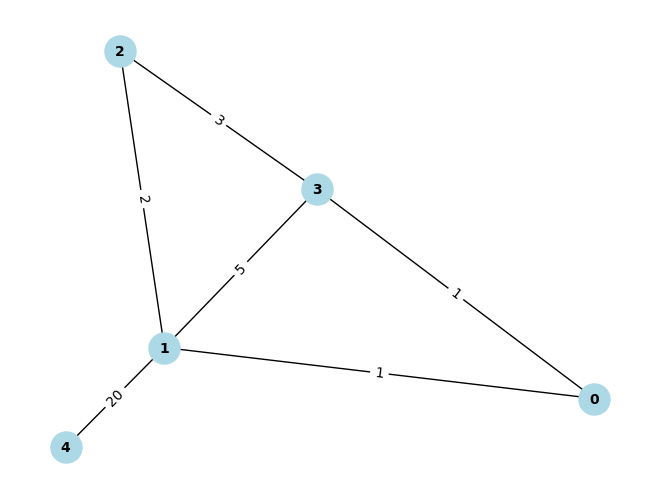

In [57]:
n = 5
G = nx.Graph()
V = range(n)
G.add_nodes_from(V)
E = [(0, 1, 1), (1, 2, 2), (2, 3, 3), (3, 0, 1), (1, 3, 5),(1, 4, 20)]
G.add_weighted_edges_from(E)
ut.draw_graph(G)

First, we will solve with classical optimizer

### Gurobi

In [3]:
from gurobi_optimods.qubo import solve_qubo

In [9]:
Q = ut.get_QUBO_Matrix(G)
print("QUBO")
print(Q,"\n")

result = solve_qubo(-Q, solver_params={'MIPGap': 0.01})
print(result.objective_value)
print(result.solution)

QUBO
[[  2.  -2.   0.  -2.   0.]
 [  0.  28.  -4. -10. -40.]
 [  0.   0.   5.  -6.   0.]
 [  0.   0.   0.   9.   0.]
 [  0.   0.   0.   0.  20.]] 

New QUBO solution found with objective 0.0
New QUBO solution found with objective -29.0
-29.0
[1. 0. 0. 1. 1.]


### Fixstar

Import Fixstar from Amplify

In [4]:
from amplify import FixstarsClient, solve, VariableGenerator
from datetime import timedelta

For Fixstar, we need to construct Quadratic part and Linear part seperately

In [58]:
w = nx.adjacency_matrix(G).todense()
max_cut = Maxcut(w)
qp = max_cut.to_quadratic_program()
Quadratic = qp.objective.quadratic.to_array()
Linear = qp.objective.linear.to_array()

Get key token for Amplify

In [5]:
from dotenv import load_dotenv
import os

load_dotenv()
FIXSTAR_TOKEN = os.getenv("FIXSTAR_TOKEN")

In [26]:
client = FixstarsClient()
client.token = FIXSTAR_TOKEN
client.parameters.timeout = timedelta(milliseconds=1000)
client.parameters.outputs.num_outputs = 0

Construct Module. For detail https://amplify.fixstars.com/en/docs/amplify/v1/index.html

In [27]:
gen = VariableGenerator()
m = gen.matrix("Binary", n)
m.quadratic = -Quadratic
m.linear = -Linear
result = solve(m, client)

In [28]:
print("execution time : " + str(result.execution_time))
q = m.variable_array
print(f"solution : {q.evaluate(result.best.values)}")
print(f"objective = {-result.best.objective}")
print(m)

execution time : 0:00:00.993974
solution : [0. 0. 0. 1. 1.]
objective = 29.0
(x^T) Q x + (p^T) x + c
where:
  x = [q_0, q_1, q_2, q_3, q_4],
  Q = [[ -0.,   2.,  -0.,   2.,  -0.],
       [ -0.,  -0.,   4.,  10.,  40.],
       [ -0.,  -0.,  -0.,   6.,  -0.],
       [ -0.,  -0.,  -0.,  -0.,  -0.],
       [ -0.,  -0.,  -0.,  -0.,  -0.]],
  p = [ -2., -28.,  -5.,  -9., -20.],
  c = 0


Note that, there are several solutions to get best objective value (29)

#### Next we will solve problem with Quantum Computer simulater

### Qiskit

In [29]:
max_cut = Maxcut(w)
qp = max_cut.to_quadratic_program()
qubitOp, offset = qp.to_ising()
print(qubitOp)

SparsePauliOp(['IIIZZ', 'IZIIZ', 'IIZZI', 'IZIZI', 'ZIIZI', 'IZZII'],
              coeffs=[ 0.5+0.j,  0.5+0.j,  1. +0.j,  2.5+0.j, 10. +0.j,  1.5+0.j])


We will solve problem with [QAOA](https://arxiv.org/pdf/1411.4028)

In [11]:
from qiskit.circuit.library import QAOAAnsatz
import numpy as np
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from scipy.optimize import minimize
from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit.primitives import StatevectorSampler as Sampler

In [31]:
reps = 1
circuit = QAOAAnsatz(cost_operator=qubitOp, reps=reps)

pm = generate_preset_pass_manager(optimization_level=3)
candidate_circuit = pm.run(circuit)

initial_gamma = np.pi
initial_beta = np.pi/2
init_params = []
for _ in range(reps):
    init_params.extend([initial_gamma, initial_beta])

Let define Objective function value

In [32]:
objective_func_vals = []
def cost_func_estimator(params, ansatz, hamiltonian, estimator):
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)
    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])
    results = job.result()[0]
    cost = results.data.evs
    objective_func_vals.append(cost)
    return cost

In [33]:
estimator = Estimator()
result = minimize(
    cost_func_estimator,
    init_params,
    args=(candidate_circuit, qubitOp, estimator),
    method="COBYLA",
    tol=1e-3,
    options={'disp': True}
)
print(result)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3.2053523530747308
       x: [ 3.556e+00  2.775e+00]
    nfev: 63
   maxcv: 0.0


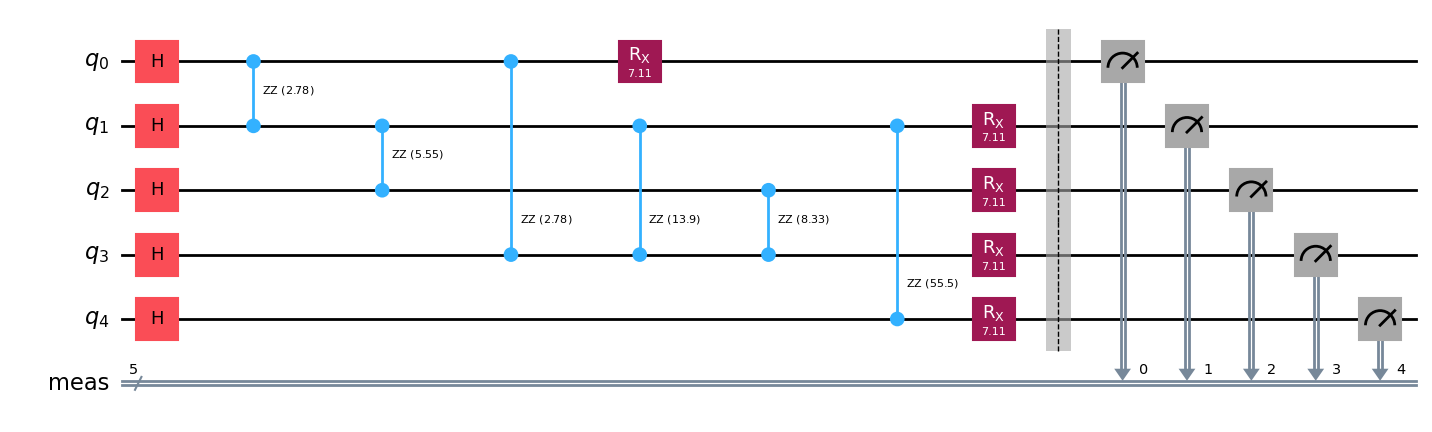

In [34]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.measure_all()
optimized_circuit.draw('mpl', fold=False, idle_wires=False)

In [35]:
# auxiliary functions to sample most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

In [36]:
sampler = Sampler() 

pub = (optimized_circuit, )

job = sampler.run([pub], shots=1024)
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}
print(final_distribution_int)

{29: 0.0556640625, 17: 0.09765625, 13: 0.0380859375, 14: 0.1123046875, 16: 0.0361328125, 30: 0.0224609375, 19: 0.0625, 24: 0.033203125, 12: 0.0595703125, 28: 0.07421875, 2: 0.0537109375, 4: 0.005859375, 3: 0.0595703125, 7: 0.0263671875, 18: 0.0341796875, 21: 0.0234375, 15: 0.0361328125, 23: 0.0107421875, 22: 0.013671875, 1: 0.01953125, 5: 0.001953125, 20: 0.0146484375, 0: 0.015625, 9: 0.0146484375, 31: 0.0126953125, 8: 0.01171875, 11: 0.01171875, 25: 0.0107421875, 26: 0.0009765625, 6: 0.0048828125, 10: 0.01953125, 27: 0.005859375}


In [37]:
keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, 5)
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

Result bitstring: [0, 1, 1, 1, 0]


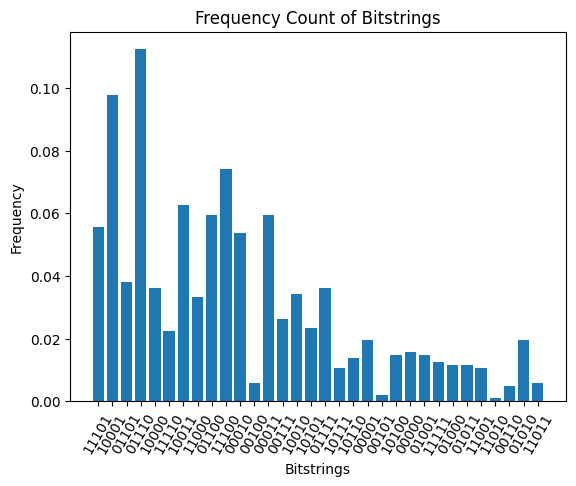

In [38]:
def plot_frequency_count(bitstring_counts):
    # Extract the bitstrings and their corresponding frequencies
    bitstrings = list(bitstring_counts.keys())
    frequencies = list(bitstring_counts.values())

    # Create a bar chart
    plt.bar(bitstrings, frequencies)
    plt.xlabel('Bitstrings')
    plt.ylabel('Frequency')
    plt.title('Frequency Count of Bitstrings')
    plt.xticks(rotation=60)
    plt.show()

plot_frequency_count(final_distribution_bin)

You will see that there are many solution in the distribution, and the most frequency bit strings isn't the best solution.

The problem lies within the QAOA algorithm. As its full name, Quantum Approximate Optimization Algorithm, suggests, it is designed to approximate solutions and may not always find the quantum state that yields the ideal answer.

The core of QAOA consists of several rotation gates, whose number depends on the integer parameter p, and it uses classical optimizers to determine the rotation angles. These gates explore the solution space but do not cover every possible quantum state, including the ideal one.

To obtain a better answer, there are several ways to do.
1. Increasing the Value of p (referred to as reps in the code)
    
    - The larger p, the more expressive your circuit gets. Ideally, when p goes to infinity, the minimum solution your circuit gives will increase, known as approximation ratio. 
    - In contrast, it'll require more quantum resources and increase noise.
2. Improve Classical Optimizers, such as Adam or L-BFGS.


However, it is important to remember that these approaches does not guarantee finding the ideal answer. Nevertheless, it does increase the minimum quality of the solution provided by the circuit, thereby improving the approximation ratio.

### D-Wave

In [11]:
w = nx.adjacency_matrix(G).todense()
max_cut = Maxcut(w)
qp = max_cut.to_quadratic_program()
Quadratic = qp.objective.quadratic.to_array()
Linear = qp.objective.linear.to_array()

Import DWave from Amplify

In [13]:
from amplify import DWaveSamplerClient

Get DWAVE TOKEN from .env

In [14]:
DWAVE_TOKEN = os.getenv("DWAVE_TOKEN")

In [13]:
client = DWaveSamplerClient()
client.token = DWAVE_TOKEN
client.parameters.num_reads = 1000

In [16]:
gen = VariableGenerator()
m = gen.matrix("Binary", n)
m.quadratic = -Quadratic
m.linear = -Linear
result = solve(m, client)

In [17]:
print("execution time : " + str(result.execution_time))
q = m.variable_array
print(f"solution : {q.evaluate(result.best.values)}")
print(f"objective = {-result.best.objective}")
print(m)

execution time : 0:00:00.139883
solution : [0. 1. 1. 0. 0.]
objective = 29.0
(x^T) Q x + (p^T) x + c
where:
  x = [q_0, q_1, q_2, q_3, q_4],
  Q = [[ -0.,   2.,  -0.,   2.,  -0.],
       [ -0.,  -0.,   4.,  10.,  40.],
       [ -0.,  -0.,  -0.,   6.,  -0.],
       [ -0.,  -0.,  -0.,  -0.,  -0.],
       [ -0.,  -0.,  -0.,  -0.,  -0.]],
  p = [ -2., -28.,  -5.,  -9., -20.],
  c = 0


### Hybrid D-Wave

import LeapHybridSampler

In [6]:
from dwave.system import LeapHybridSampler

Construct sampler

In [60]:
sampler = LeapHybridSampler(token=DWAVE_TOKEN)

In [61]:
Q = ut.get_QUBO_Matrix(G)

Solve QUBO

In [64]:
print(Q)

[[  2.  -2.   0.  -2.   0.]
 [  0.  28.  -4. -10. -40.]
 [  0.   0.   5.  -6.   0.]
 [  0.   0.   0.   9.   0.]
 [  0.   0.   0.   0.  20.]]


In [65]:
response = sampler.sample_qubo(-Q)

In [67]:
best_sample = response.first.sample
best_energy = response.first.energy

print("Best solution:", [best_sample[k] for k in best_sample])
print("Execution time:", response.info['qpu_access_time']/10**6)
print("Best energy:", -best_energy)

Best solution: [0, 1, 1, 0, 0]
Execution time: 0.064256
Best energy: 29.0


<h1 style="font-size:3em; "> Scaling The Problem </h1>
I'll use graph from RandomGraph function in Utils/graph.py with number of nodes from 5 to .........

In [11]:
nodeSizes = range(5, 176, 10) # Fix here
seed = 696969
graphList = [ut.getRandomGraph(n, seed=seed) for n in nodeSizes]
QUBOList = [ut.get_QUBO_Matrix(G) for G in graphList]

df = pd.DataFrame({
    '#vertices': [len(G.nodes()) for G in graphList],
    '#edges': [len(G.edges()) for G in graphList],
})

I'll write each solver in function for conciseness

In [159]:
import time

# Construct Quadratic and Linear part and construct module
def getModule(G: nx.Graph):
    # Return m: Module
    w = nx.adjacency_matrix(G).todense()
    max_cut = Maxcut(w)
    qp = max_cut.to_quadratic_program()
    Quadratic = qp.objective.quadratic.to_array()
    Linear = qp.objective.linear.to_array()

    gen = VariableGenerator()
    m = gen.matrix("Binary", len(G.nodes()))
    m.quadratic = -Quadratic
    m.linear = -Linear
    return m

# Gurobi
def solveWithGurobi(G: nx.Graph):
    Q = ut.get_QUBO_Matrix(G)

    start_time = time.time()
    result = solve_qubo(-Q, solver_params={'MIPGap': 0.10})
    end_time = time.time()
    takeTime = end_time - start_time
    takeTime = timedelta(seconds=takeTime)

    ret = {
        'execution_time': takeTime,
        'best_values': result.solution,
        'objective': result.objective_value,
    }
    return ret

# Fixstar
def solveWithFixstar(G: nx.Graph):
    fsClient = FixstarsClient()
    fsClient.token = FIXSTAR_TOKEN
    fsClient.parameters.outputs.num_outputs = 0

    m = getModule(G)
    result = solve(m, fsClient)
    arr = m.variable_array

    ret = {
        'execution_time': result.solutions[0].time.total_seconds(),
        'best_values': arr.evaluate(result.best.values),
        'objective': result.best.objective,
    }
    return ret

# DWave
def solveWithDWave(G: nx.Graph, solver="Advantage_system6.4", num_reads=1000):
    dwClient = DWaveSamplerClient()
    dwClient.token = DWAVE_TOKEN
    dwClient.solver = solver
    dwClient.parameters.num_reads = num_reads

    m = getModule(G)
    result = solve(m, dwClient)
    arr = m.variable_array

    ret = {
        'execution_time': result.solutions[0].time.total_seconds(),
        'best_values': arr.evaluate(result.best.values),
        'objective': result.best.objective,
    }
    return ret

def solveWithHybridDwave(G: nx.Graph) :
    sampler = LeapHybridSampler(token=DWAVE_TOKEN)
    
    Q = ut.get_QUBO_Matrix(G)
    response = sampler.sample_qubo(-Q)

    solution  = [response.first.sample[b] for b in response.first.sample]

    ret = {
        'execution_time': response.info['qpu_access_time']/10**6,
        'best_value': solution,
        'objective': response.first.energy
    }
    return ret

In [25]:
# Function to solve each graph multiple times and calculate averages
def solve_graph_multiple_times(graph_list, solve_function, iterations=5):
    results = []

    for graph in graph_list:
        execution_times = []
        objectives = []

        for _ in range(iterations):
            result = solve_function(graph)
            execution_times.append(result['execution_time'])
            objectives.append(result['objective'])

        avg_execution_time = np.mean(execution_times)
        avg_objective = np.mean(objectives)

        results.append({
            "execution_time": avg_execution_time,
            "objective": avg_objective
        })

    return results

In [160]:
fsResult = solve_graph_multiple_times(graphList, solveWithFixstar)
dwResult = solve_graph_multiple_times(graphList, solveWithDWave)
#gbResult = [solveWithGurobi(G) for G in graphList]
hbResult = solve_graph_multiple_times(graphList, solveWithHybridDwave)

In [162]:
dataToConcat = {
    #'gbTime': [res['execution_time'] for res in gbResult],
    #'gbValue': [res['objective'] for res in gbResult],
    'fsTime': [res['execution_time'] for res in fsResult],
    'fsValue': [res['objective'] for res in fsResult],
    'dwTime': [res['execution_time'] for res in dwResult],
    'dwValue': [res['objective'] for res in dwResult],
    'hybridTime': [res['execution_time'] for res in hbResult],
    'hybridValue' : [res['objective'] for res in hbResult]
}

newDf = df.join(pd.DataFrame(dataToConcat, index=range(len(df))))
newDf['fsValue'] = -newDf['fsValue']
newDf['dwValue'] = -newDf['dwValue']
newDf['hybridValue'] = -newDf['hybridValue']
print(newDf)

    #vertices  #edges    fsTime  fsValue                 dwTime  dwValue  \
0           5       5  0.027811     30.0 0 days 00:00:00.086747     30.0   
1          15      53  0.036392    219.0 0 days 00:00:00.094311    219.0   
2          25     151  0.046211    542.0 0 days 00:00:00.099266    542.0   
3          35     288  0.053916    955.0 0 days 00:00:00.105825    952.6   
4          45     502  0.055396   1607.0 0 days 00:00:00.124067   1592.0   
5          55     761  0.070270   2350.0 0 days 00:00:00.125389   2306.2   
6          65    1059  0.056654   3251.0 0 days 00:00:00.133627   3170.4   
7          75    1411  0.058267   4287.0 0 days 00:00:00.127566   4140.8   
8          85    1775  0.065487   5333.0 0 days 00:00:00.133448   4826.2   
9          95    2217  0.068916   6618.0 0 days 00:00:00.179089   5730.6   
10        105    2694  0.059036   7973.0 0 days 00:00:00.188527   7031.6   
11        115    3254  0.061089   9537.0 0 days 00:00:00.195430   8028.6   
12        12

In [163]:
from tabulate import tabulate

# Save DataFrame as a formatted text file
with open("results_table.txt", "w") as f:
    f.write(tabulate(newDf, headers=newDf.columns, tablefmt="plain"))

# Display the saved text file content
with open("results_table.txt", "r") as f:
    print(f.read())


      #vertices    #edges     fsTime    fsValue  dwTime                    dwValue    hybridTime    hybridValue
 0            5         5  0.0278112         30  0 days 00:00:00.086747       30       0.141342              30
 1           15        53  0.036392         219  0 days 00:00:00.094311      219       0.150563             219
 2           25       151  0.0462114        542  0 days 00:00:00.099266      542       0.124099             542
 3           35       288  0.053916         955  0 days 00:00:00.105825      952.6     0.0780184            955
 4           45       502  0.0553958       1607  0 days 00:00:00.124067     1592       0.150651            1607
 5           55       761  0.07027         2350  0 days 00:00:00.125389     2306.2     0.190498            2350
 6           65      1059  0.0566542       3251  0 days 00:00:00.133627     3170.4     0.201913            3251
 7           75      1411  0.058267        4287  0 days 00:00:00.127566     4140.8     0.215885         

In [169]:
def tabulated_file_to_list_of_dicts(file_path):
    list_of_dicts = []

    with open(file_path, 'r') as file:
        lines = file.readlines()
        
        # Extract headers from the first line
        headers = [header.strip() for header in lines[0].split()]
        
        # Process each subsequent line
        for line in lines[1:]:
            # Split the line into values
            values = line.split()
            # Map headers to values
            row_dict = {headers[i]: values[i] for i in range(len(headers))}
            list_of_dicts.append(row_dict)
    
    return list_of_dicts

# File path of the saved text file
file_path = "results_table.txt"

# Convert to list of dictionaries
result = tabulated_file_to_list_of_dicts(file_path)
# print(result)

for x in result: 
    print(x)

{'num': '0', '#vertices': '5', '#edges': '5', 'fsTime': '0.0278112', 'fsValue': '30', 'dwTime': '0.086747', 'dwValue': '30', 'hybridTime': '0.141342', 'hybridValue': '30'}
{'num': '1', '#vertices': '15', '#edges': '53', 'fsTime': '0.036392', 'fsValue': '219', 'dwTime': '0.094311', 'dwValue': '219', 'hybridTime': '0.150563', 'hybridValue': '219'}
{'num': '2', '#vertices': '25', '#edges': '151', 'fsTime': '0.0462114', 'fsValue': '542', 'dwTime': '0.099266', 'dwValue': '542', 'hybridTime': '0.124099', 'hybridValue': '542'}
{'num': '3', '#vertices': '35', '#edges': '288', 'fsTime': '0.053916', 'fsValue': '955', 'dwTime': '0.105825', 'dwValue': '952.6', 'hybridTime': '0.0780184', 'hybridValue': '955'}
{'num': '4', '#vertices': '45', '#edges': '502', 'fsTime': '0.0553958', 'fsValue': '1607', 'dwTime': '0.124067', 'dwValue': '1592', 'hybridTime': '0.150651', 'hybridValue': '1607'}
{'num': '5', '#vertices': '55', '#edges': '761', 'fsTime': '0.07027', 'fsValue': '2350', 'dwTime': '0.125389', 'd

[30.0, 219.0, 542.0, 955.0, 1607.0, 2350.0, 3251.0, 4287.0, 5333.0, 6618.0, 7973.0, 9537.0, 11273.0, 13179.0, 15278.0, 17386.0, 19625.0, 22010.0]
[30.0, 219.0, 542.0, 952.6, 1592.0, 2306.2, 3170.4, 4140.8, 4826.2, 5730.6, 7031.6, 8028.6, 9641.6, 11587.6, 13024.6, 15384.0, 17266.0, 19518.6]
[30.0, 219.0, 542.0, 955.0, 1607.0, 2350.0, 3251.0, 4287.0, 5333.0, 6618.0, 7973.0, 9537.0, 11273.0, 13179.0, 15278.0, 17386.0, 19625.0, 22010.0]


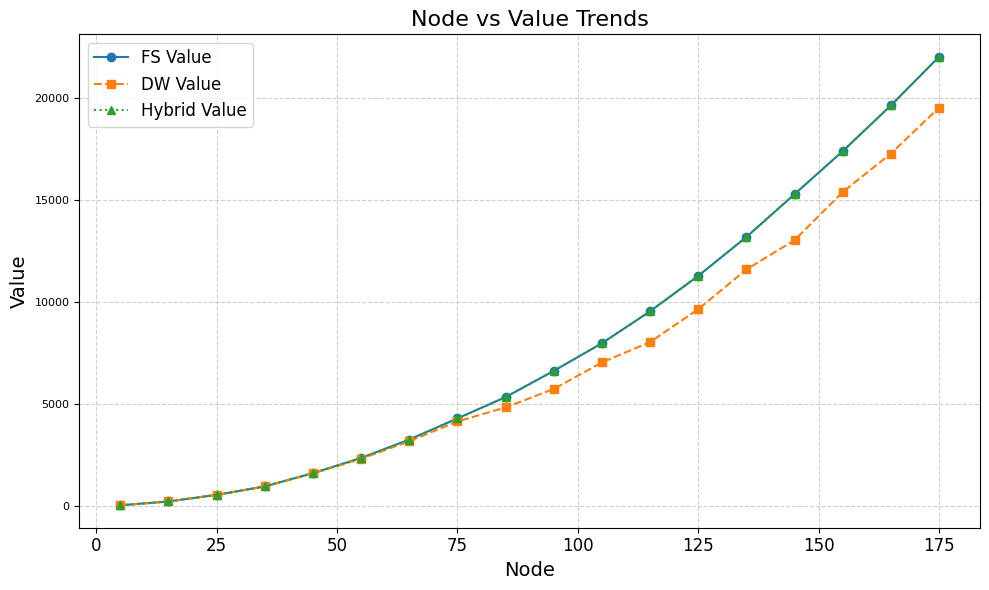

In [170]:
node = [int(item['#vertices']) for item in result]
fs_value = [float(item['fsValue']) for item in result]
dw_value = [float(item['dwValue']) for item in result]
hybrid_value = [float(item['hybridValue']) for item in result]
print(fs_value)
print(dw_value)
print(hybrid_value)

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(node, fs_value, label="FS Value", marker='o', linestyle='-')
plt.plot(node, dw_value, label="DW Value", marker='s', linestyle='--')
plt.plot(node, hybrid_value, label="Hybrid Value", marker='^', linestyle=':')

# Adding labels, title, and legend
plt.title("Node vs Value Trends", fontsize=16)
plt.xlabel("Node", fontsize=14)
plt.ylabel("Value", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=12)
plt.yticks(fontsize=8)

# Display the graph
plt.tight_layout()
plt.show()

[0.0278112, 0.036392, 0.0462114, 0.053916, 0.0553958, 0.07027, 0.0566542, 0.058267, 0.0654872, 0.0689162, 0.0590362, 0.0610886, 0.0643684, 0.0526022, 0.0568796, 0.058885, 0.0532264, 0.0568994]
[0.086747, 0.094311, 0.099266, 0.105825, 0.124067, 0.125389, 0.133627, 0.127566, 0.133448, 0.179089, 0.188527, 0.19543, 0.197465, 0.200045, 0.20985, 0.216829, 0.220906, 0.224652]
[0.141342, 0.150563, 0.124099, 0.0780184, 0.150651, 0.190498, 0.201913, 0.215885, 0.2278, 0.236016, 0.249914, 0.229376, 0.266176, 0.251168, 0.201486, 0.214419, 0.240793, 0.188936]


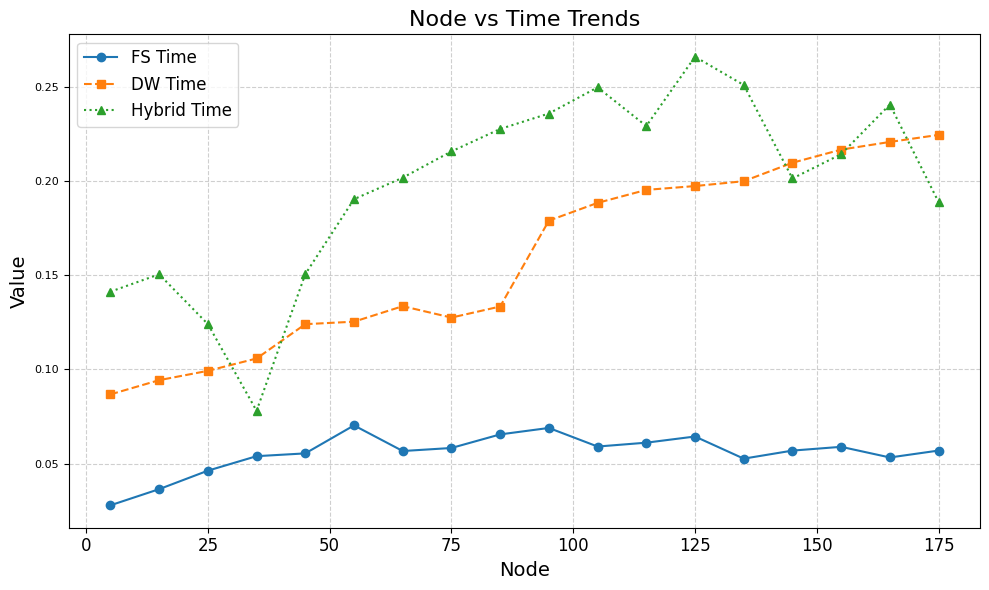

In [171]:
node = [int(item['#vertices']) for item in result]
fs_time = [float(item['fsTime']) for item in result]
dw_time = [float(item['dwTime']) for item in result]
hybrid_time = [float(item['hybridTime']) for item in result]
print(fs_time)
print(dw_time)
print(hybrid_time)

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(node, fs_time, label="FS Time", marker='o', linestyle='-')
plt.plot(node, dw_time, label="DW Time", marker='s', linestyle='--')
plt.plot(node, hybrid_time, label="Hybrid Time", marker='^', linestyle=':')

# Adding labels, title, and legend
plt.title("Node vs Time Trends", fontsize=16)
plt.xlabel("Node", fontsize=14)
plt.ylabel("Value", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=12)
plt.yticks(fontsize=8)

# Display the graph
plt.tight_layout()
plt.show()